In [1]:
!nvidia-smi

Mon Nov 15 09:14:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:65:00.0 Off |                  N/A |
|100%   75C    P0   171W / 370W |     45MiB / 24265MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:B3:00.0 Off |                  N/A |
| 84%   

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import skimage.transform as st
import os
from PIL import Image
import gc
import seaborn as sns
import IPython
import warnings
import collections
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from IPython import display
 
print(tf.__version__)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type='GPU')

2.5.0


In [3]:
def test_CI(y_preds, y_test):
    
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_preds), len(y_preds)) # random sample another part and get auc --> get 1000 results 
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_test[indices], y_preds[indices])
        bootstrapped_scores.append(score)
        
#     plt.hist(bootstrapped_scores, bins=100)
#     plt.title('Histogram of the bootstrapped ROC AUC scores')
#     plt.show()
    
    auc_score = np.array(bootstrapped_scores)
    
    mean_score = auc_score.mean()
    std_dev = auc_score.std()
    std_error = std_dev / np.math.sqrt(1)
    ci =  2.262 * std_error
    lower_bound = mean_score - ci
    upper_bound = mean_score + ci

    print("Sample auc mean: {:0.2f}". format(mean_score))
    print("Samole auc std: {:0.2f}".format(std_dev))
    print("Sample auc CI: {:0.2f}". format(ci))
    print("Confidence interval for AUC: [{:0.2f} - {:0.2f}]".format(
        lower_bound, upper_bound))
    
    return mean_score
    
def plot_cm(y_preds, y_test):
    cf = confusion_matrix(y_test, np.round(y_preds))

    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(y_test))) # length of classes
    class_labels = ['0','1']

    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')

    plt.show()

In [4]:
def get_thresh(y_test, y_preds):
    fprs, tprs, thresh = roc_curve(y_test, y_preds, drop_intermediate=False)
    
    diff = tprs-fprs
#     diff = np.sqrt(tprs * (1 - fprs))
    idx = np.argmax(diff)
    
    return thresh[idx]

In [5]:
def freeze_layer(model, layer_name):
    for layer in model.layers:
#     number of blocks to be freezed is also a hyperparameter
        if (layer.name == layer_name):
            break
        else:
            layer.trainable = False
    return model

# Pretrain model

In [4]:
Labels_diseases = ['Atelectasis', 'Cardiomegaly', 'Edema', 'Lung Opacity', 'Pleural Effusion', 'Support Devices']
features = { i : tf.io.FixedLenFeature([], tf.float32) for i in Labels_diseases }

files = '../Data/Chexpert_cxr.tfrecords'

INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32

def parse_TFrecord(example):
    img = tf.io.parse_single_example(example, {'jpg_bytes': tf.io.FixedLenFeature([], tf.string)})
    img = tf.io.decode_jpeg(img['jpg_bytes'], channels=3)
    # Normalize the pixel values to be between 0 and 1
    img = (1.0 / 255.0) * tf.cast(tf.image.resize(img, [256, 256]), tf.float32)
    
    label = tf.io.parse_single_example(example, features)
    Label = tf.stack([label[l] for l in Labels_diseases], axis=0)
        
    return img, Label

train_dataset = (tf.data.TFRecordDataset(
    files, compression_type=None, buffer_size=32, num_parallel_reads=32)
.map(parse_TFrecord)
.batch(BATCH_SIZE, drop_remainder=True)
.shuffle(256, reshuffle_each_iteration=True))

In [5]:
def scheduler(epoch, lr): # decrease the lr 
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(patience=4)]

In [ ]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

def define_model():
#     base_model = tf.keras.applications.densenet.DenseNet121(
#             include_top=False, weights='imagenet', input_shape=INPUT_SHAPE, pooling='max')
    
    base_model = tf.keras.applications.InceptionV3(
            include_top=False, weights='imagenet', input_shape=INPUT_SHAPE, pooling='max')
    
    pred_layer = tf.keras.layers.Dense(6, activation='sigmoid')(base_model.output)
 
    model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer, name='model')  
  
    return model

model = define_model()

model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='AUC')

model.fit(train_dataset, epochs=10, shuffle=True, callbacks=callback)

model.save('saved_model/Chexpert_pretrained_256_6_labels_InceptionV3')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

   3156/Unknown - 293s 90ms/step - loss: 0.5132 - auc: 0.7922

# Transfer learning

In [6]:
# get_testing data from tfrecord
def get_test_data(Race=-1):
    
    filename = 'copd_test_new.tfrecords' 
        
    X_test = []
    y_test = []

    #load the test files
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        
        label = example.features.feature['COPD'].int64_list.value[0]
        race = example.features.feature['race'].int64_list.value[0]
        
        if (race > 4):
            race = 3
        
        if (Race > -1):
            if (race != Race):
                continue
        
        nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8) #extract  img info --in bytes list format convert to np array
        img_np = cv.imdecode(nparr, cv.IMREAD_COLOR) #open cv convert to gray scale IMREAD_GRAYSCALE -- RBG uses pretrained weights need RGB

        X_test.append(np.float32(st.resize(img_np, (256, 256))))

        y_test.append(label)
     
    return np.array(X_test), np.array(y_test)

## Data augmentation

In [7]:
IMG_SIZE = 256

# Create a generator

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05), fill_mode='constant')
])

In [8]:
# parse tfrecord for training

def filter_1(img, label):
    return (tf.math.equal(label, 1))

def filter_0(img, label):
    return (tf.math.equal(label, 0))

def parse_TFrecord(example):
    img = tf.io.parse_single_example(example, {'jpg_bytes': tf.io.FixedLenFeature([], tf.string)}) # Parse images to keras dataset
    img = tf.io.decode_jpeg(img['jpg_bytes'], channels=3) #RBG image
    # Normalize the pixel values to be between 0 and 1
    img = (1.0 / 255.0) * tf.cast(tf.image.resize(img, [256, 256]), tf.float32) #Normalize pixel 
    
    copd = tf.io.parse_single_example(example, {'COPD' :tf.io.FixedLenFeature([], tf.int64)}) # parses the label copd

    if (tf.math.equal(copd['COPD'], 0)):
        label = tf.constant(0)
    elif(tf.math.equal(copd['COPD'], 1)):
        label = tf.constant(1) 
    else:
        label = tf.constant(-1)

    return img, label

In [9]:
pos = 27297
neg = 119133

total = pos+neg

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr
callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(mode='min', patience=4)]

Weight for class 0: 0.61
Weight for class 1: 2.68


## Ensemble 

In [10]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

BATCH_SIZE = 32

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr

record_file_train = 'copd_train_new.tfrecords'
train_dataset = (tf.data.TFRecordDataset(
    record_file_train, buffer_size=BATCH_SIZE*10)
.map(parse_TFrecord)
.shuffle(pos+neg)
.batch(BATCH_SIZE))

record_file_val = 'copd_val_new.tfrecords'
val_dataset = (tf.data.TFRecordDataset(
    record_file_val, buffer_size=BATCH_SIZE*10)
.map(parse_TFrecord)
.shuffle(26980)
.batch(BATCH_SIZE))

In [9]:
checkpoint_filepath = 'checkpoints/checkpoint_cw_InceptionV3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(mode='min', patience=4, monitor='val_loss'),
            model_checkpoint_callback]

base_model = tf.keras.models.load_model('saved_model/Chexpert_pretrained_256_6_labels_InceptionV3')

pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(base_model.get_layer('global_max_pooling2d').output)

model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer, name='model') 

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='AUC')

model.fit(train_dataset, epochs=20, shuffle=True, validation_data=val_dataset, callbacks=callback, class_weight=class_weight)

del model, base_model, pred_layer
gc.collect()

435

In [ ]:
X_test, y_test = get_test_data()

checkpoint_filepath = 'checkpoints/checkpoint_cw_InceptionV3'
model_path = 'saved_model/Chexpert_pretrained_256_6_labels_InceptionV3'
InceptionV3 = tf.keras.models.load_model(model_path)
pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(InceptionV3.get_layer('global_max_pooling2d').output)
InceptionV3 = tf.keras.Model(inputs=InceptionV3.input, outputs=pred_layer, name='model')
InceptionV3.load_weights(checkpoint_filepath)

checkpoint_filepath = 'checkpoints/checkpoint_cw_densenet121'
model_path = 'saved_model/Chexpert_pretrained_256_6_labels'
densenet121 = tf.keras.models.load_model(model_path)
pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(densenet121.get_layer('max_pool').output)
densenet121 = tf.keras.Model(inputs=densenet121.input, outputs=pred_layer, name='model')
densenet121.load_weights(checkpoint_filepath)

y_preds_IV3 = InceptionV3.predict(X_test)
y_preds_D121 = densenet121.predict(X_test)

y_preds_vote = (y_preds_densenet + y_preds_IV3)/2
    
y_preds_vote = np.array(y_preds_vote)
    
test_CI(y_preds_vote, y_test)
    
thresh = get_thresh(y_test, y_preds_vote)
        
print(classification_report(y_test, np.where(y_preds_vote >= thresh, 1, 0)))
print(average_precision_score(y_test, y_preds_vote, average=None))

gc.collect()

In [68]:
def get_ensemble_mlp():
    inputs_a = tf.keras.Input(shape=(2048))
    a = tf.keras.layers.Dense(512, activation=swish_activation)(inputs_a)
    a = tf.keras.layers.Dense(256, activation=swish_activation)(a)
    a = tf.keras.layers.Dense(128, activation=swish_activation)(a)

    inputs_b = tf.keras.Input(shape=(1024))
    b = tf.keras.layers.Dense(512, activation=swish_activation)(inputs_b)
    b = tf.keras.layers.Dense(256, activation=swish_activation)(b)
    b = tf.keras.layers.Dense(128, activation=swish_activation)(b)

    concate = tf.keras.layers.Concatenate()([a, b])
    concate = tf.keras.layers.Dense(64, activation=swish_activation)(concate)
    concate = tf.keras.layers.Dense(32, activation=swish_activation)(concate)
    concate = tf.keras.layers.Dense(8, activation=swish_activation)(concate)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(concate)

    model = tf.keras.Model(inputs=[inputs_a, inputs_b], outputs=pred)
    
    return model

In [16]:
def get_label(split):
    
    if (split=='train'):
        filename = 'copd_train_new.tfrecords'
    elif (split=='test'):
        filename = 'copd_test_new.tfrecords'
    else:
        filename = 'copd_val_new.tfrecords'
        
    y = []

    #load the test files
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        
        label = example.features.feature['COPD'].int64_list.value[0]
        race = example.features.feature['race'].int64_list.value[0]

        y.append(label)
     
    return np.array(y)

In [65]:
y_train = get_label('train')
y_val = get_label('val')

In [ ]:
checkpoint_filepath = 'checkpoints/checkpoint_cw_InceptionV3'
model_path = 'saved_model/Chexpert_pretrained_256_6_labels_InceptionV3'
InceptionV3 = tf.keras.models.load_model(model_path)
pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(InceptionV3.get_layer('global_max_pooling2d').output)
InceptionV3 = tf.keras.Model(inputs=InceptionV3.input, outputs=pred_layer, name='model')
InceptionV3.load_weights(checkpoint_filepath)

checkpoint_filepath = 'checkpoints/checkpoint_cw_densenet121'
model_path = 'saved_model/Chexpert_pretrained_256_6_labels'
densenet121 = tf.keras.models.load_model(model_path)
pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(densenet121.get_layer('max_pool').output)
densenet121 = tf.keras.Model(inputs=densenet121.input, outputs=pred_layer, name='model')
densenet121.load_weights(checkpoint_filepath)

InceptionV3 = tf.keras.Model(inputs=InceptionV3.input, outputs=InceptionV3.get_layer('global_max_pooling2d').output)
densenet121 = tf.keras.Model(inputs=densenet121.input, outputs=densenet121.get_layer('max_pool').output)

# features_IV3 = InceptionV3.predict(train_dataset)
# features_D121 = densenet121.predict(train_dataset)

# features_val_IV3 = InceptionV3.predict(val_dataset)
# features_val_D121 = densenet121.predict(val_dataset)

# ensemble_mlp = get_ensemble_mlp()

# ensemble_mlp.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='AUC')

# ensemble_mlp.fit([features_IV3, features_D121], y_train, epochs=20, shuffle=True, validation_data=([features_val_IV3, features_val_D121],  y_val), callbacks=callback, class_weight=class_weight)

In [ ]:
ensemble_mlp.save('saved_model/ensemble_mlp')

In [13]:
record_file_val = 'copd_test_new.tfrecords'
test_dataset = (tf.data.TFRecordDataset(
    record_file_val, buffer_size=32*10)
.map(parse_TFrecord)
.batch(32))

y_test = get_label('test')

Sample auc mean: 0.50
Samole auc std: 0.00
Sample auc CI: 0.00
Confidence interval for AUC: [0.50 - 0.50]


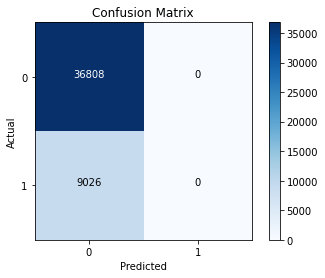

              precision    recall  f1-score   support

           0       0.92      0.00      0.00     36808
           1       0.20      1.00      0.33      9026

    accuracy                           0.20     45834
   macro avg       0.56      0.50      0.16     45834
weighted avg       0.78      0.20      0.07     45834

0.19696208974952817


5919

In [20]:
X_test_IV3 = InceptionV3.predict(test_dataset)
X_test_D121 = densenet121.predict(test_dataset)

ensemble_mlp = tf.keras.models.load_model('saved_model/ensemble_mlp')

y_preds = ensemble_mlp.predict([X_test_IV3, X_test_D121])

test_CI(y_preds, y_test)

plot_cm(y_preds, y_test)

thresh = get_thresh(y_test, y_preds)

print(classification_report(y_test, np.where(y_preds >= thresh, 1, 0)))
print(average_precision_score(y_test, y_preds, average=None))

gc.collect()

## Class weight

In [10]:
import tensorflow_addons as tfa
# @tf.function

def binary_focal_loss(y_true, y_pred):
    return tfa.losses.sigmoid_focal_crossentropy(
        y_true,
        y_pred,
        alpha=1,
        gamma=2,
        from_logits=True
    )

In [ ]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

BATCH_SIZE = 32

checkpoint_filepath = 'checkpoints/PrecisionAtRecall/checkpoint_focal'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_precision_at_recall',
    mode='max')

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr
    
callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(mode='max', patience=4, monitor='val_precision_at_recall'),
            model_checkpoint_callback]

record_file_train = 'copd_train_new.tfrecords'
train_dataset = (tf.data.TFRecordDataset(
    record_file_train, buffer_size=BATCH_SIZE*10)
.map(parse_TFrecord)
.shuffle(pos+neg)
.batch(BATCH_SIZE))

record_file_val = 'copd_val_new.tfrecords'
val_dataset = (tf.data.TFRecordDataset(
    record_file_val, buffer_size=BATCH_SIZE*10)
.map(parse_TFrecord)
.shuffle(26980)
.batch(BATCH_SIZE))

base_model = tf.keras.models.load_model('saved_model/Chexpert_pretrained_256_6_labels')

base_model = freeze_layer(base_model, 'pool3_pool')

pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(base_model.get_layer('max_pool').output)

model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer, name='model') 

# tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(loss=binary_focal_loss,
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.55)])

model.fit(train_dataset, epochs=20, shuffle=True, validation_data=val_dataset, callbacks=callback)

# model.save('saved_model/Chexpert_256_fine_tuned_class_weight')
model.load_weights(checkpoint_filepath)

del train_dataset, val_dataset
gc.collect()

Epoch 1/20
4576/4576 [==============================] - 475s 100ms/step - loss: 0.0042 - precision_at_recall: 0.1865 - val_loss: 0.0039 - val_precision_at_recall: 0.1723
Epoch 2/20
4425/4576 [============================>.] - ETA: 13s - loss: 0.0042 - precision_at_recall: 0.1864

Sample auc mean: 0.73
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.72 - 0.73]


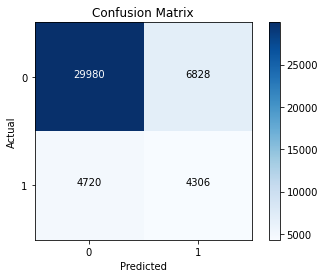

              precision    recall  f1-score   support

           0       0.89      0.67      0.76     36808
           1       0.33      0.67      0.44      9026

    accuracy                           0.67     45834
   macro avg       0.61      0.67      0.60     45834
weighted avg       0.78      0.67      0.70     45834

0.39728980982040846


6406

In [36]:
checkpoint_filepath = 'checkpoints/PrecisionAtRecall/checkpoint_cw'

base_model = tf.keras.models.load_model('saved_model/Chexpert_pretrained_256_6_labels')

pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(base_model.get_layer('max_pool').output)

model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer, name='model') 

model.load_weights(checkpoint_filepath)

X_test, y_test = get_test_data()

y_preds = model.predict(X_test)

test_CI(y_preds, y_test)

plot_cm(y_preds, y_test)

thresh = get_thresh(y_test, y_preds)

print(classification_report(y_test, np.where(y_preds >= thresh, 1, 0)))
print(average_precision_score(y_test, y_preds, average=None))

del X_test, y_test, y_preds
gc.collect()

Sample auc mean: 0.72
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.71 - 0.73]


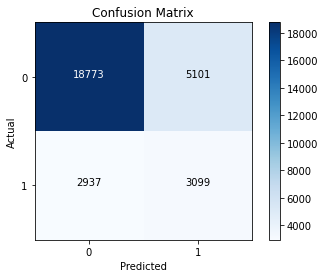

              precision    recall  f1-score   support

           0       0.89      0.65      0.75     23874
           1       0.33      0.68      0.44      6036

    accuracy                           0.66     29910
   macro avg       0.61      0.66      0.60     29910
weighted avg       0.78      0.66      0.69     29910

0.39899444501318965
Sample auc mean: 0.75
Samole auc std: 0.01
Sample auc CI: 0.02
Confidence interval for AUC: [0.73 - 0.76]


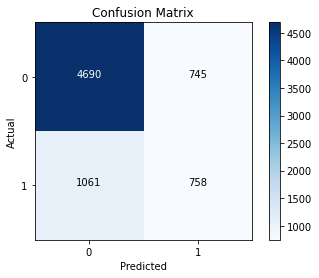

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      5435
           1       0.41      0.72      0.52      1819

    accuracy                           0.66      7254
   macro avg       0.64      0.68      0.63      7254
weighted avg       0.76      0.66      0.69      7254

0.4944283833199838
Sample auc mean: 0.73
Samole auc std: 0.01
Sample auc CI: 0.03
Confidence interval for AUC: [0.70 - 0.75]


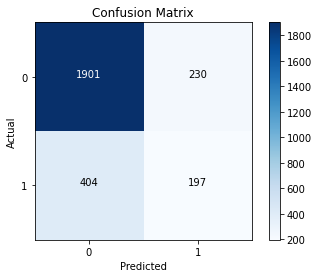

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      2131
           1       0.37      0.67      0.48       601

    accuracy                           0.68      2732
   macro avg       0.63      0.68      0.62      2732
weighted avg       0.77      0.68      0.71      2732

0.42993837761334197
Sample auc mean: 0.76
Samole auc std: 0.01
Sample auc CI: 0.03
Confidence interval for AUC: [0.73 - 0.78]


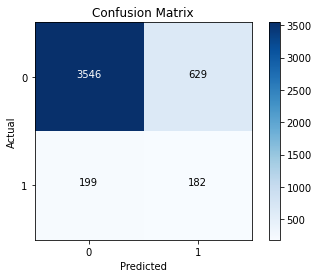

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      4175
           1       0.18      0.68      0.29       381

    accuracy                           0.72      4556
   macro avg       0.57      0.70      0.56      4556
weighted avg       0.90      0.72      0.78      4556

0.21835281527496986
Sample auc mean: 0.74
Samole auc std: 0.02
Sample auc CI: 0.05
Confidence interval for AUC: [0.69 - 0.79]


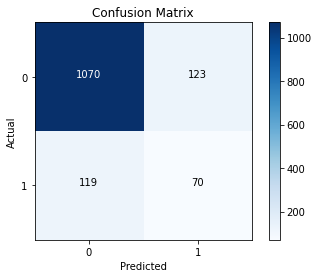

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1193
           1       0.30      0.60      0.40       189

    accuracy                           0.75      1382
   macro avg       0.61      0.69      0.62      1382
weighted avg       0.84      0.75      0.78      1382

0.3826738591565314


In [37]:
for i in range(5):

    X_test, y_test = get_test_data(i)

    y_preds = model.predict(X_test)

    test_CI(y_preds, y_test)

    plot_cm(y_preds, y_test)
    
    thresh = get_thresh(y_test, y_preds)

    print(classification_report(y_test, np.where(y_preds >= thresh, 1, 0)))
    print(average_precision_score(y_test, y_preds, average=None))

    del X_test, y_test, y_preds
    gc.collect()

## Augmentation

In [14]:
BATCH_SIZE = 32
checkpoint_filepath = 'checkpoints/PrecisionAtRecall/checkpoint_aug'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_precision_at_recall',
    mode='max')

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr
    
callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(mode='max', patience=4, monitor='val_precision_at_recall'),
            model_checkpoint_callback]

record_file_train = 'copd_train_new.tfrecords'
train_majority = (tf.data.TFRecordDataset(
    record_file_train, compression_type=None, buffer_size=32, num_parallel_reads=32)
.map(parse_TFrecord)
.filter(filter_0) # filter out negative cases
.shuffle(neg)) # based on augmentation, no augmentation them just take 6057, do flip augmentation them take 6057*2

train_minority = (tf.data.TFRecordDataset(
    record_file_train, compression_type=None, buffer_size=32, num_parallel_reads=32)
.map(parse_TFrecord)
.filter(filter_1)) # filter out positive cases

train_dataset = train_majority.concatenate(train_minority) # concatenate positive and negative cases
train_dataset = train_dataset.concatenate(train_minority.batch(1).map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.AUTOTUNE).unbatch())
train_dataset = train_dataset.shuffle(neg+pos*2).batch(BATCH_SIZE)

record_file_val = 'copd_val_new.tfrecords'
val_dataset = (tf.data.TFRecordDataset(
    record_file_val, compression_type=None, buffer_size=32, num_parallel_reads=32)
.map(parse_TFrecord)
.batch(BATCH_SIZE))

base_model = tf.keras.models.load_model('saved_model/Chexpert_pretrained_256_6_labels')

flag = 0
for layer in base_model.layers:
#     number of blocks to be freezed is also a hyperparameter
    if (layer.name == 'pool3_pool'):
        break
    else:
        layer.trainable = False

pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(base_model.output) # add output layer

model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer, name='model')  

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.55)])

model.fit(train_dataset, epochs=20, shuffle=True, validation_data=val_dataset, callbacks=callback)

# model.save('saved_model/Chexpert_256_fine_tuned_class_weight')
model.load_weights(checkpoint_filepath)

del train_dataset, val_dataset
gc.collect()

Epoch 1/20
5429/5429 [==============================] - 579s 97ms/step - loss: 0.4073 - precision_at_recall: 0.8223 - val_loss: 0.4431 - val_precision_at_recall: 0.3026
Epoch 2/20
5429/5429 [==============================] - 569s 96ms/step - loss: 0.3671 - precision_at_recall: 0.9168 - val_loss: 0.4360 - val_precision_at_recall: 0.3185
Epoch 3/20
5429/5429 [==============================] - 571s 96ms/step - loss: 0.3510 - precision_at_recall: 0.9389 - val_loss: 0.4283 - val_precision_at_recall: 0.3047
Epoch 4/20
5429/5429 [==============================] - 569s 96ms/step - loss: 0.3385 - precision_at_recall: 0.9548 - val_loss: 0.4336 - val_precision_at_recall: 0.3181
Epoch 5/20
5429/5429 [==============================] - 571s 96ms/step - loss: 0.3216 - precision_at_recall: 0.9678 - val_loss: 0.4235 - val_precision_at_recall: 0.3259
Epoch 6/20
5429/5429 [==============================] - 569s 96ms/step - loss: 0.3038 - precision_at_recall: 0.9763 - val_loss: 0.4578 - val_precision_at_r

1839

In [14]:
def rotation(angle, img_np, to_resize):
    return transform.rotate(img_np, angle, resize=to_resize)

In [15]:
# get_testing data from tfrecord
from skimage import transform
def get_test_data(Race=-1):
    
    np.random.seed(42)
    
    filename = 'copd_test_new.tfrecords' 
        
    X_test = []
    y_test = []

    #load the test files
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        
        label = example.features.feature['COPD'].int64_list.value[0]
        race = example.features.feature['race'].int64_list.value[0]
        
        if (race > 4):
            race = 3
        
        if (Race > -1):
            if (race != Race):
                continue
        
        nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8) #extract  img info --in bytes list format convert to np array
        img_np = cv.imdecode(nparr, cv.IMREAD_COLOR) #open cv convert to gray scale IMREAD_GRAYSCALE -- RBG uses pretrained weights need RGB

        X_test.append(np.float16(st.resize(img_np, (256, 256))))
        
        angle = np.random.uniform(-9, 9)
        img_np = rotation(angle, img_np, False)
        X_test.append(np.float16(st.resize(img_np, (256, 256))))

        y_test.append(label)
     
    return np.array(X_test), np.array(y_test)

In [12]:
checkpoint_filepath = 'checkpoints/PrecisionAtRecall/checkpoint_aug'

base_model = tf.keras.models.load_model('saved_model/Chexpert_pretrained_256_6_labels')

pred_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_layer')(base_model.output) # add output layer

model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer, name='model')  

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='Recall')

model.load_weights(checkpoint_filepath)

In [16]:
X_test, y_test = get_test_data()

y_vote = []
    
for i in range(len(y_test)):
    y_preds = model.predict(X_test[2*i:2*i+2])
    y_vote.append(y_preds[0]+y_preds[1])
y_vote = np.array(y_vote)

y_vote = np.genfromtxt("Aug_vote_pred.csv", delimiter=",")
y_vote /= 2.

test_CI(y_vote, y_test)

# plot_cm(y_vote, y_test)

thresh = get_thresh(y_test, y_vote)

print(classification_report(y_test, np.where(y_vote >= thresh, 1, 0)))
print(average_precision_score(y_test, y_vote, average=None))

del X_test, y_test, y_vote
gc.collect()

Sample auc mean: 0.71
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.70 - 0.72]
              precision    recall  f1-score   support

           0       0.88      0.71      0.79     36808
           1       0.35      0.62      0.44      9026

    accuracy                           0.69     45834
   macro avg       0.61      0.67      0.62     45834
weighted avg       0.78      0.69      0.72     45834

0.38796580129559566


106815

In [18]:
for i in range(5):

    X_test, y_test = get_test_data(i)

    y_vote = []
    
    for i in range(len(y_test)):
        y_preds = model.predict(X_test[2*i:2*i+2])
        y_vote.append(y_preds[0]+y_preds[1])
    y_vote = np.array(y_vote).reshape(len(y_test),)

    test_CI(y_vote, y_test)

#     plot_cm(y_vote, y_test)

    thresh = get_thresh(y_test, y_vote)

    print(classification_report(y_test, np.where(y_vote >= thresh, 1, 0)))
    print(average_precision_score(y_test, y_vote, average=None))

    del X_test, y_test, y_vote
    gc.collect()

Sample auc mean: 0.71
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.70 - 0.71]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     23874
           1       0.33      0.65      0.44      6036

    accuracy                           0.67     29910
   macro avg       0.61      0.66      0.60     29910
weighted avg       0.77      0.67      0.70     29910

0.3952876581250267
Sample auc mean: 0.73
Samole auc std: 0.01
Sample auc CI: 0.02
Confidence interval for AUC: [0.72 - 0.75]
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      5435
           1       0.47      0.63      0.53      1819

    accuracy                           0.73      7254
   macro avg       0.66      0.69      0.67      7254
weighted avg       0.76      0.73      0.74      7254

0.49464010716885376
Sample auc mean: 0.70
Samole auc std: 0.01
Sample auc CI: 0.03
Confidence interval for AUC: [0.

## Demographic attributes

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, concatenate

checkpoint_filepath = 'checkpoints/PrecisionAtRecall/checkpoint_demo'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_precision_at_recall',
    mode='max')

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr
callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(mode='max', patience=4, monitor='val_precision_at_recall'),
            model_checkpoint_callback]

def swish_activation(x):
    return (K.sigmoid(x) * x)

def define_model():
    input_2 = Input(shape=(10,), name='input_2') # sex - 1, age - 4, ethnicity - 5

    base_model = tf.keras.models.load_model('saved_model/Chexpert_pretrained_256_6_labels')
    
    flag = 0
    for layer in base_model.layers:
    #     number of blocks to be freezed is also a hyperparameter
        if (layer.name == 'pool3_pool'):
            break
        else:
            layer.trainable = False
    
    y = tf.keras.layers.Dense(54, activation='swish')(base_model.get_layer('max_pool').output)
    y = Model(inputs=base_model.input, outputs=y)
    
    # combine the output of the two branches
    combined = concatenate([input_2, y.output])
    x = Dense(16, activation="swish")(combined)
    x = Dense(4, activation="swish")(x)
    pred_COPD = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_COPD')(x)

    model = tf.keras.Model(inputs=[base_model.input, input_2], outputs=pred_COPD)

    return model

In [6]:
# get_testing data from tfrecord
def get_test_data(Gender=-1):
        
    filename = 'copd_test_new.tfrecords' 
        
    image = []
    demo = []
    label = []

    #load the test files
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        
        nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8) #extract  img info --in bytes list format convert to np array
        img_np = cv.imdecode(nparr, cv.IMREAD_COLOR) #open cv convert to gray scale IMREAD_GRAYSCALE -- RBG uses pretrained weights need RGB

        gender = example.features.feature['gender'].int64_list.value[0]
        race = example.features.feature['race'].int64_list.value[0]
        age = example.features.feature['age'].int64_list.value[0]
        
        if (race > 4):
            race = 3
        if (age > 0):
            age -= 1
            
#         if (Age > -1):
#             if (age != Age):
#                 continue
        if (Gender > -1):
            if (Gender != gender):
                continue
            
#         if (Race > -1):
#             if (race != Race):
#                 continue
        
        race = np.eye(5)[race]
        age = np.eye(4)[age]
        
        temp = np.concatenate((race, age, gender), axis=None)
        demo.append(temp)
        
        image.append(np.float32(st.resize(img_np, (256, 256))))
        label.append(example.features.feature['COPD'].int64_list.value[0])
                
    return np.array(image), np.array(demo), np.array(label)

In [7]:
BATCH_SIZE = 32

def parse_TFrecord(example):
    img = tf.io.parse_single_example(example, {'jpg_bytes': tf.io.FixedLenFeature([], tf.string)}) # Parse images to keras dataset
    img = tf.io.decode_jpeg(img['jpg_bytes'], channels=3) #RBG image
    # Normalize the pixel values to be between 0 and 1
    img = (1.0 / 255.0) * tf.cast(tf.image.resize(img, [256, 256]), tf.float16) #Normalize pixel 
    
    copd = tf.io.parse_single_example(example, {'COPD' :tf.io.FixedLenFeature([], tf.int64)}) # parses the label copd

    if (tf.math.equal(copd['COPD'], 0)):
        label = tf.constant(0)
    elif(tf.math.equal(copd['COPD'], 1)):
        label = tf.constant(1) 
    else:
        label = tf.constant(-1)
        
    race = tf.cast(tf.io.parse_single_example(example, {'race' :tf.io.FixedLenFeature([], tf.int64)})['race'], tf.int32)
    age = tf.cast(tf.io.parse_single_example(example, {'age' :tf.io.FixedLenFeature([], tf.int64)})['age'], tf.int32)
    gender = tf.cast(tf.io.parse_single_example(example, {'gender' :tf.io.FixedLenFeature([], tf.int64)})['gender'], tf.int32)
    
    race = tf.cond(tf.less(4, race), true_fn=lambda: tf.constant(3), false_fn=lambda: race)
    age = tf.cond(tf.less(age, 1), true_fn=lambda: age, false_fn=lambda: age-1)
    
    race = tf.one_hot(race, 5)
    age = tf.one_hot(age, 4)
    
    demo = tf.experimental.numpy.append(tf.cast(race, tf.float32), tf.cast(age, tf.float32))
    demo = tf.experimental.numpy.append(demo, tf.cast(gender, tf.float32))

    feature_dict = collections.OrderedDict(
      input_1=img,
      input_2=demo
  )

    return feature_dict, label

In [9]:
record_file_train = 'copd_train_new.tfrecords'
train_dataset = (tf.data.TFRecordDataset(
    record_file_train, compression_type=None, buffer_size=32, num_parallel_reads=32)
.map(parse_TFrecord)
.shuffle(pos+neg)
.batch(BATCH_SIZE))


record_file_val = 'copd_val_new.tfrecords'
val_dataset = (tf.data.TFRecordDataset(
    record_file_val, compression_type=None, buffer_size=32, num_parallel_reads=32)
.map(parse_TFrecord)
.shuffle(34620)
.batch(BATCH_SIZE))

In [10]:
model = define_model()

model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.55)])    

model.fit(train_dataset, epochs=20, shuffle=True, validation_data=val_dataset, callbacks=callback, class_weight=class_weight)

model.load_weights(checkpoint_filepath)

del train_dataset, val_dataset
gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
4576/4576 [==============================] - 472s 95ms/step - loss: 0.6090 - precision_at_recall: 0.3498 - val_loss: 0.6133 - val_precision_at_recall: 0.3366
Epoch 2/20
4576/4576 [==============================] - 461s 95ms/step - loss: 0.5729 - precision_at_recall: 0.4062 - val_loss: 0.5012 - val_precision_at_recall: 0.3626
Epoch 3/20
4576/4576 [==============================] - 461s 95ms/step - loss: 0.5480 - precision_at_recall: 0.4521 - val_loss: 0.7815 - val_precision_at_recall: 0.3454
Epoch 4/20
4576/4576 [==============================] - 460s 95ms/step - loss: 0.5216 - precision_at_recall: 0.4971 - val_loss: 0.5735 - val_precision_at_recall: 0.3384
Epoch 5/20
4576/4576 [==============================] - 461s 95ms/step - loss: 0.4890 - precision_at_recall: 0.5577 - val_loss: 0.5979 - val_precision_at_recall: 0.3435
Epoch 6/20
4576/4

3142

Sample auc mean: 0.75
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.74 - 0.75]


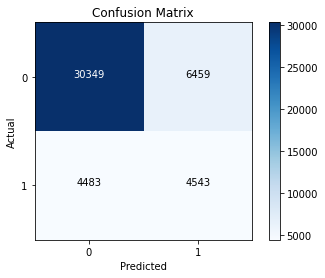

              precision    recall  f1-score   support

           0       0.90      0.69      0.78     36808
           1       0.35      0.68      0.46      9026

    accuracy                           0.69     45834
   macro avg       0.62      0.68      0.62     45834
weighted avg       0.79      0.69      0.72     45834

0.42754447498125986


6097

In [7]:
checkpoint_filepath = 'checkpoints/PrecisionAtRecall/checkpoint_demo'

model = define_model()

model.load_weights(checkpoint_filepath)

test_image, test_demo, y_test = get_test_data()

y_preds = model.predict([test_image, test_demo])

test_CI(y_preds, y_test)

plot_cm(y_preds, y_test)

thresh = get_thresh(y_test, y_preds)

print(classification_report(y_test, np.where(y_preds >= thresh, 1, 0)))
print(average_precision_score(y_test, y_preds, average=None))

del test_image, test_demo, y_test, y_preds
gc.collect()

Sample auc mean: 0.77
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.76 - 0.78]


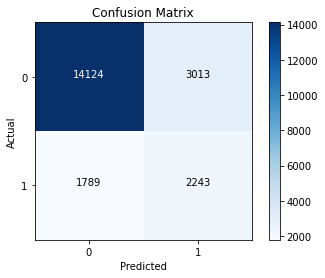

              precision    recall  f1-score   support

           0       0.91      0.69      0.79     17137
           1       0.36      0.72      0.48      4032

    accuracy                           0.70     21169
   macro avg       0.63      0.71      0.63     21169
weighted avg       0.81      0.70      0.73     21169

0.44917141906622976
Sample auc mean: 0.73
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for AUC: [0.72 - 0.74]


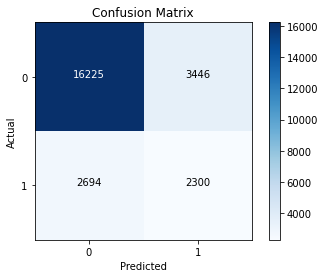

              precision    recall  f1-score   support

           0       0.89      0.61      0.73     19671
           1       0.32      0.72      0.44      4994

    accuracy                           0.63     24665
   macro avg       0.61      0.66      0.58     24665
weighted avg       0.78      0.63      0.67     24665

0.4111233272996033


In [8]:
for i in range(2):

    test_image, test_demo, y_test = get_test_data(i)

    y_preds = model.predict([test_image, test_demo])

    test_CI(y_preds, y_test)

    plot_cm(y_preds, y_test)

    thresh = get_thresh(y_test, y_preds)

    print(classification_report(y_test, np.where(y_preds >= thresh, 1, 0)))
    print(average_precision_score(y_test, y_preds, average=None))

    del test_image, test_demo, y_test, y_preds
    gc.collect()